In [6]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
import scipy.ndimage
from IPython.display import display, Audio
from activation_learner import ActivationLearner
import scipy.signal
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger("activation_learner").setLevel(logging.DEBUG)

In [7]:
def fade(a: np.ndarray, b: np.ndarray, l: int):
    curve = np.linspace(0, 1, l)
    a_fade = a[-l:] * (1 - curve)
    b_fade = b[:l] * curve
    return np.concatenate([a[:-l], a_fade + b_fade, b[l:]])


def lowpass_filter(data, cutoff_freq, sampling_rate, order=1):
    """
    Apply a 1st order lowpass filter to the data.

    Parameters:
    - data: numpy array containing the signal to be filtered
    - cutoff_freq: cutoff frequency in Hz
    - sampling_rate: sampling rate in Hz
    - order: order of the filter

    Returns:
    - filtered_data: numpy array containing the filtered signal
    """
    # Normalize the cutoff frequency
    normal_cutoff = cutoff_freq / (0.5 * sampling_rate)

    # Design the Butterworth filter
    sos = scipy.signal.butter(
        order, normal_cutoff, btype="low", analog=False, output="sos"
    )

    # Apply the filter to the data
    filtered_data = scipy.signal.sosfilt(sos, data)
    return filtered_data

In [8]:
# Load audios

FS = 22050
ref_paths = ["linear-mix-1.wav", "linear-mix-2.wav"]
mix_path = "linear-mix.wav"
# ref_paths = ["original.wav"]
# mix_path = "original.wav"
# mix_path = "boucled.wav"
# ref_paths = ["amen.wav", "high.wav"]
# mix_path = "nuttah.wav"
# ref_paths = ["nuttah.wav"]
# mix_path= "nuttah-timestretch.wav"
refs = [librosa.load(i, sr=FS)[0] for i in ref_paths]
mix = librosa.load(mix_path, sr=FS)[0]

# generate chirps
# t = np.linspace(0, 2, int(2 * FS))
# refs = [
    # scipy.signal.chirp(t, 200, 2, 5000) + scipy.signal.chirp(t, 500, 2, 8000),
    # scipy.signal.chirp(t, 4000, 2, 800) + scipy.signal.chirp(t, 8000, 2, f1=600),
# ]
# mix = fade(refs[0], refs[1], int(0.5 * FS))
# mix += librosa.load("nuttah.wav", sr=FS)[0][: len(mix)] * 1

# mix += librosa.load("maya.wav", sr=FS)[0][: len(mix)] * 0.3
# mix /= mix.max()

# ## alignment test
# t = np.arange(FS) / FS
# sig = np.concatenate(
#     [
#         np.sin(2 * np.pi * 2000 * t),
#         np.sin(2 * np.pi * 4000 * t),
#         np.sin(2 * np.pi * 6000 * t),
#     ]
# )
# sig = scipy.signal.chirp(t, 800, t[-1], 2000)
# refs = [sig]
# mix = np.concatenate([np.ones(3 * FS) * 1e-50, sig])

display(Audio(mix, rate=FS))
for i, x in enumerate(refs):
    print(i)
    display(Audio(x, rate=FS))

0


1


DEBUG:activation_learner:Shape of W: (513, 1333)
DEBUG:activation_learner:Shape of H: (1333, 969)
DEBUG:activation_learner:Shape of V: (513, 969)


NFFT=1024 HLEN=256


  0%|          | 0/100 [00:00<?, ?it/s]

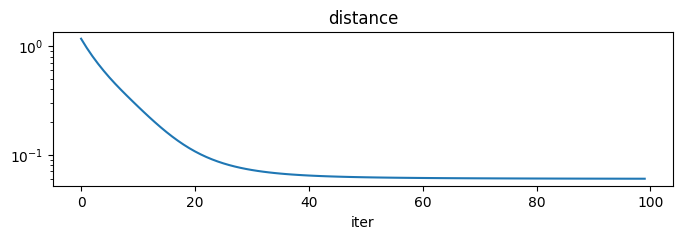

In [9]:
NFFT = 1024
HLEN = 256
print(f"{NFFT=} {HLEN=}")

model = ActivationLearner(
    mix,
    refs,
    transform=lambda x: librosa.stft(x, n_fft=NFFT, hop_length=HLEN, center=True),
    inv_transform=lambda S: librosa.istft(S, n_fft=NFFT, hop_length=HLEN, center=True),
    # transform = lambda x: abs(librosa.cqt(x, sr=FS, hop_length=HLEN)),
    # inv_transform=lambda S: librosa.icqt(S, sr=FS, hop_length=HLEN),
    # transform = lambda x: abs(librosa.feature.mfcc(y=x, sr=FS)),
    # inv_transform=lambda mfcc: librosa.feature.inverse.mfcc_to_audio(mfcc),
    # transform = lambda x: librosa.feature.melspectrogram(y=x, sr=FS, n_fft=NFFT, hop_length=HLEN, power=1, n_mels=300),
    # inv_transform = lambda S: librosa.feature.inverse.mel_to_audio(S, sr=FS, n_fft=NFFT, hop_length=HLEN, power=1, n_mels=300),
    additional_dim=0,
)
losses = []
for i in (pbar := tqdm(range(100))):
    loss = model.iterate()
    losses.append(loss)
    pbar.set_description(f"loss={loss:.2e}")
plt.figure(figsize=(8, 2))
plt.plot(losses)
plt.xlabel("iter")
plt.title("distance")
plt.yscale("log")

<>:53: SyntaxWarning: invalid escape sequence '\h'
<>:53: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_13674/1554794774.py:53: SyntaxWarning: invalid escape sequence '\h'
  axes[1, 1].set_title("$\hat{V} = WH$ (estimated mix)")


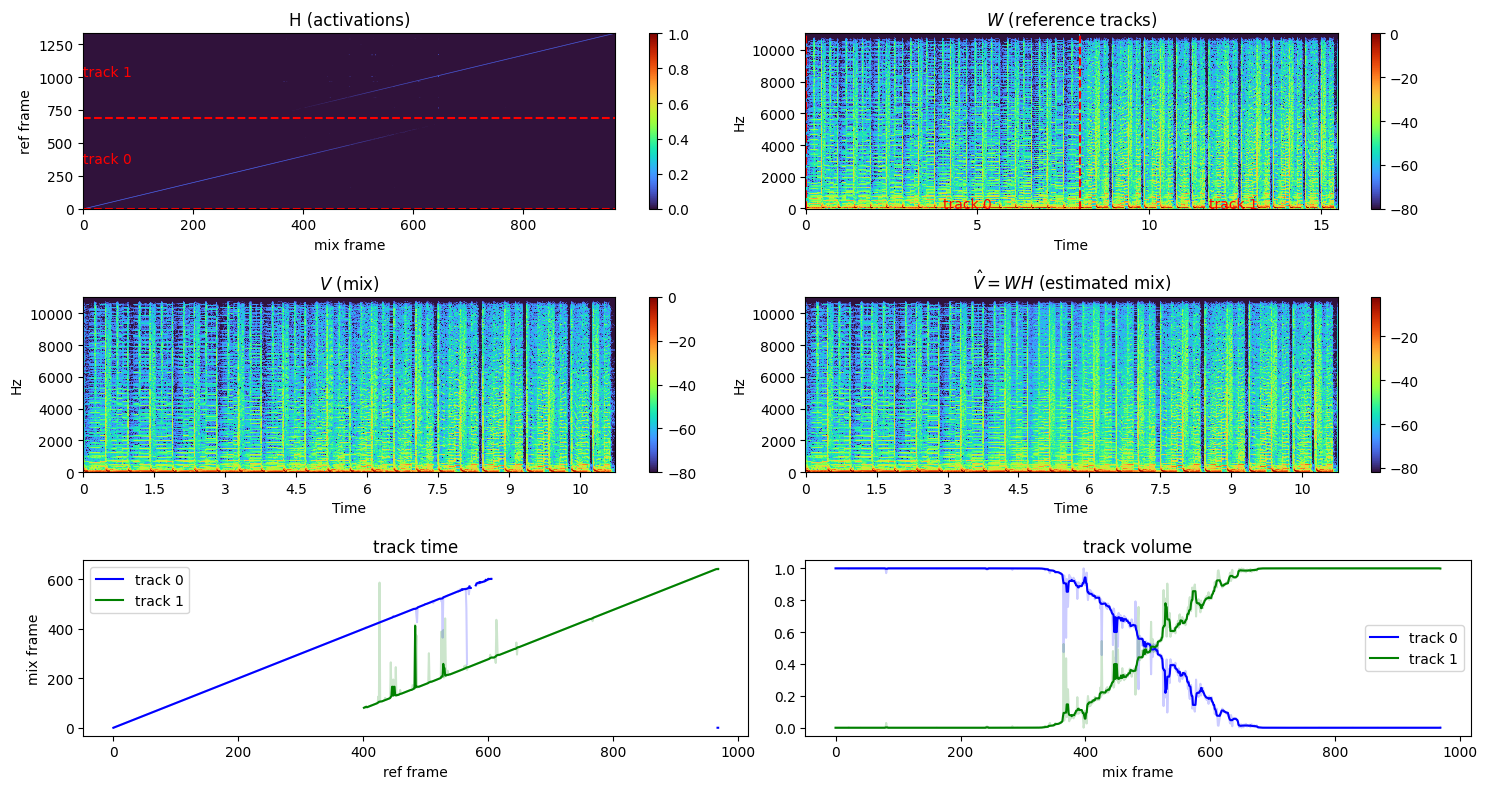

In [10]:
CMAP = "turbo"
# Plot the H matrix
fig, axes = plt.subplots(3, 2, figsize=(15, 8))

im = axes[0, 0].imshow(model.nmf.H, cmap=CMAP, aspect="auto", origin="lower")
axes[0, 0].set_title("H (activations)")
axes[0, 0].set_xlabel("mix frame")
axes[0, 0].set_ylabel("ref frame")
fig.colorbar(im, ax=axes[0, 0])

im = librosa.display.specshow(
    librosa.power_to_db(model.nmf.W),
    ax=axes[0, 1],
    cmap=CMAP,
    hop_length=HLEN,
    n_fft=NFFT,
    sr=FS,
    x_axis="time",
    y_axis="fft",
)
fig.colorbar(mappable=im, ax=axes[0, 1])
axes[0, 1].set_title("$W$ (reference tracks)")

for track, (a, b) in enumerate(zip(model.split_idx, model.split_idx[1:])):
    axes[0, 0].axhline(a, color="r", linestyle="--")
    axes[0, 0].annotate(f"track {track}", (0, (a + b) / 2), color="red")
    axes[0, 1].axvline(a / FS * HLEN, color="r", linestyle="--")
    axes[0, 1].annotate(f"track {track}", ((a + b) / 2 / FS * HLEN, 1), color="red")

im = librosa.display.specshow(
    librosa.power_to_db(model.nmf.V),
    ax=axes[1, 0],
    cmap=CMAP,
    hop_length=HLEN,
    n_fft=NFFT,
    sr=FS,
    x_axis="time",
    y_axis="fft",
)
axes[1, 0].set_title("$V$ (mix)")
fig.colorbar(mappable=im, ax=axes[1, 0])

im = librosa.display.specshow(
    librosa.power_to_db(model.nmf.W @ model.nmf.H),
    ax=axes[1, 1],
    cmap=CMAP,
    hop_length=HLEN,
    n_fft=NFFT,
    sr=FS,
    x_axis="time",
    y_axis="fft",
)
axes[1, 1].set_title("$\hat{V} = WH$ (estimated mix)")
fig.colorbar(mappable=im, ax=axes[1, 1])

colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black"]
for i, v in enumerate(
    iterable=model.position(threshold=5e-3, weiner=None, medfilt=None)
):
    axes[2, 0].plot(v, alpha=0.2, color=colors[i % len(colors)])
for i, v in enumerate(iterable=model.position(threshold=5e-3)):
    axes[2, 0].plot(v, label=f"track {i}", color=colors[i % len(colors)])
axes[2, 0].legend()
axes[2, 0].set_title("track time")
axes[2, 0].set_xlabel("ref frame")
axes[2, 0].set_ylabel("mix frame")


for i, v in enumerate(iterable=model.volume(weiner=None, medfilt=None)):
    axes[2, 1].plot(v, alpha=0.2, color=colors[i % len(colors)])
for i, v in enumerate(model.volume()):
    axes[2, 1].plot(v, label=f"track {i}", color=colors[i % len(colors)])
axes[2, 1].legend()
axes[2, 1].set_title("track volume")
axes[2, 1].set_xlabel("mix frame")

plt.tight_layout()
plt.show()

In [11]:
import soundfile as sf


def estimate_tracks():
    ret = []
    for i in range(len(refs) + 1):
        xi = model.reconstruct(i)
        ret.append(xi)
        print("track", i)
        display(Audio(xi, rate=FS))
        sf.write(f"estimated-{i}.wav", xi / xi.max(), FS)
    return ret


estimates = estimate_tracks()
# sdr, isr, sir, sar = museval.evaluate(
#     np.expand_dims(np.vstack(refs), axis=-1),
#     np.expand_dims(np.vstack(estimates), axis=-1),
# )

track 0


track 1


IndexError: list index out of range